# A simple feed forward neural network

Neural networks are amazing. When properly constructed, they can be used to perform specific tasks such as image recognition and language translation. They are complex machines however, grounded in mathematics and require diligent tuning efforts to get right. Typically, neural networks are designed with a specific task in mind, and the network architecture reflects characteristics of the problem.

The search for architectures suitable for specific tasks is an ongoing one, however you may be familiar with some of the architectures that have been discovered so far. One such architecture is the convolutional neural network (ConvNet). Another is the recurrent neural network (RNN). ConvNets have enjoyed much success in the domain of image recognition, where a characteristic of the problem is the correlative nature of pixel values when forming images, whereas RNNs tend to perform well on sequence based tasks, where signal is embedded in the order of sequence elements.

The simplest kind of neural network is called a restricted bolztmann machine, also called the feed-forward network, which is what we'll focus on in this notebook. When you break down some of the more advanced architectures, it becomes apparent that they are basically just clever ways to combine various feed-forward networks that use the same mathematical operations we'll learn about by building a simple feed-forward network.

So using our understanding of vector and matrix operations, let's implement a feed-forward network from scratch using numpy!

## What we'll cover

#### In this notebook, we'll go over:
 - how to build a simple neural network to approximate a mathematical function
 - explore the limitations of a purely linear network
 - explore how using non-linear functions in the network all us to model non-linear mathematical functions
 - how to set up some data for training
 - how to implement the forward pass of a neural network
 - how to predict housing prices using a NN

#### and if we have time:
 - how modern NN libraries attempt to abstract layers by implementing a layer class
 - how we can implement a NN using keras
 - how we can implement a NN using TF

#### What we'll gloss over

We won't spend too much time discussing the mechanics of training; backpropogation and gradient descent. This will be covered in the next session.

### The operations at the ends of the network

In the previous session we talked about some of the mathematical operations that happen inside of a feed-forward network, but we haven't talked about any of the operations that happen on either end.

Neural networks essentially learn to generalize a data distribution, so to train a network we need some input data and the target distribution. On the input end of the network, we typically need to consider getting our data cleaned and organized in such a way that that we can feed it in as a vector (but as a single row in a 2d matrix). On the other end of the network (i.e. the output end), we need a loss function to compute the loss and drive the network towards the goal that we'd like to  optimize for.

#### The data

For this tutorial, we will use a standard dataset that does not require much preprocessing. This is to keep things as simple as possible. We can focus on these things in a later session. Input preprocessing tends to be different for each network you create, and loss functions will be discussed when we cover the the training process in greater depth.

#### Imports

In [198]:
import numpy as np
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

### Implement a purely linear network

Neural networks devoid of non-linear funcitons can, at best, model linear functions. For a  

#### Define a few helper functions

In [10]:
def batch_data_gen(batch_size):
    " Generate inputs and outputs in batches "
    xs = np.random.randint(-10, 10, size=[batch_size, 1]).astype(np.float32)
    ys = (xs ** 2).astype(np.float32)
    return xs, ys

def loss_function(pred, targ):
    return 0.5 * np.sum((pred - targ)**2)

def loss_function_deriv(pred, targ):
    return (pred - targ)

def logistic(x, use=True, deriv=False):
    if use:
        if deriv is True:
            return x * (1 - x)
        return 1./(1. + np.exp(-x))
    else:
        return x if deriv is False else 1 #return 1 if computing the deriv (same as removing)

def predict(x, use_nonlinearity, hidden_weights, output_weights, hidden_bias, output_bias):
    out = logistic(np.dot(x, hidden_weights) + hidden_bias, use=use_nonlinearity)
    pred = np.dot(out, output_weights) + output_bias
    return pred

#### Fit the data to approximate $f(x) = x^2$ using a linear network

We can flip the 'use' switch in the logistic function and its derivative to see what happens when we have non-linearities in the network vs not having non-linearities.

In [ ]:
lr = 0.0001
num_iterations = 15000
n_input_features = 1
hidden_size = 32
batch_size = 25
samples_seen = 0
progress = list()

use_nonlinearity = False

# Set learnable weight matrices
hidden_weights = np.random.normal(loc=0.0, scale=0.01, size=(n_input_features, hidden_size))
hidden_bias = np.zeros((1, hidden_size))

output_weights = np.random.normal(loc=0.0, scale=0.01, size=(hidden_size, 1))  # a single output!
output_bias = np.zeros((1, 1))

losses = list()

# Train the network
for _ in range(num_iterations):
    xs, ys = batch_data_gen(batch_size)
    samples_seen += 1 * batch_size

    # Forward Pass
    hidden_layer_out = logistic(np.dot(xs, hidden_weights) + hidden_bias, use=use_nonlinearity)
    pred = np.dot(hidden_layer_out, output_weights) + output_bias

    # error
    err = loss_function(pred, ys)
    losses.append(np.sum(err))

    # backprop
    out_delta = loss_function_deriv(pred, ys) # pred - ys
    hidden_delta = np.dot(out_delta, output_weights.T) * logistic(hidden_layer_out, use=use_nonlinearity, deriv=True)

    # gradient descent - use minus-equals due to order of (pred - ys), if switched (ys - pred), use plus-equals
    output_weights -= np.dot(hidden_layer_out.T, out_delta) * lr
    output_bias -= np.sum(out_delta, axis=0) * lr

    hidden_weights -= np.dot(xs.T, hidden_delta) * lr
    hidden_bias -= np.sum(hidden_delta, axis=0) * lr

    if _ % 500 == 0:
        print(f"Current batch loss: {round(losses[-1], 2)} ... samples seen: {samples_seen}")
        x = np.linspace(-9, 9, 30).reshape(-1, 1)
        progress.append(predict(x, use_nonlinearity, hidden_weights, output_weights, hidden_bias, output_bias))

# Print out a cool plot of the learning progress
x = np.linspace(-9, 9, 30).reshape(-1, 1)
fig, axes = plt.subplots(ncols=5, nrows=3, figsize=(15,12))
step = 0
for out, ax, los in zip(progress, axes.flatten(), losses):
    ax.plot(x, x **2, alpha=0.3)
    ax.scatter(x, out)
    ax.set_title('Step: {}\nloss: {}'.format(str(step), str(round(los, 2))))
    step += 1000
plt.tight_layout()

## Use a neural network to approximate a regression function that predicts housing prices

#### Load the dataset

For this network, we'll use the Boston housing dataset. The goal for this dataset is to learn a model that helps us predict the median market value of the house based on features gathered associated with the property. This is ideal for a simple neural network since we want to use a simple loss function. Since we're predicting a price, we can frame this as a regression problem and use a sum of squares loss function.

In [2]:
boston = load_boston(return_X_y=False)

In [3]:
print(boston.DESCR)

Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
      

#### Note for those who are wondering about the race based feature
This appears to be a controversial feature related to race in the context of a toy dataset where we would like to perform regression. The original purpose of this feature was to rule out race as a confounding factor in the original study. For perspective on both sides of the debate as to whether or not this should be included, you can follow up by reading: https://mail.python.org/pipermail/scikit-learn/2017-July/001683.html

Since this tutorial does not require this feature, we will exclude it.

#### Visualize the data

In [4]:
boston.data

array([[6.3200e-03, 1.8000e+01, 2.3100e+00, ..., 1.5300e+01, 3.9690e+02,
        4.9800e+00],
       [2.7310e-02, 0.0000e+00, 7.0700e+00, ..., 1.7800e+01, 3.9690e+02,
        9.1400e+00],
       [2.7290e-02, 0.0000e+00, 7.0700e+00, ..., 1.7800e+01, 3.9283e+02,
        4.0300e+00],
       ...,
       [6.0760e-02, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9690e+02,
        5.6400e+00],
       [1.0959e-01, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9345e+02,
        6.4800e+00],
       [4.7410e-02, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9690e+02,
        7.8800e+00]])

In [5]:
boston.target

array([24. , 21.6, 34.7, 33.4, 36.2, 28.7, 22.9, 27.1, 16.5, 18.9, 15. ,
       18.9, 21.7, 20.4, 18.2, 19.9, 23.1, 17.5, 20.2, 18.2, 13.6, 19.6,
       15.2, 14.5, 15.6, 13.9, 16.6, 14.8, 18.4, 21. , 12.7, 14.5, 13.2,
       13.1, 13.5, 18.9, 20. , 21. , 24.7, 30.8, 34.9, 26.6, 25.3, 24.7,
       21.2, 19.3, 20. , 16.6, 14.4, 19.4, 19.7, 20.5, 25. , 23.4, 18.9,
       35.4, 24.7, 31.6, 23.3, 19.6, 18.7, 16. , 22.2, 25. , 33. , 23.5,
       19.4, 22. , 17.4, 20.9, 24.2, 21.7, 22.8, 23.4, 24.1, 21.4, 20. ,
       20.8, 21.2, 20.3, 28. , 23.9, 24.8, 22.9, 23.9, 26.6, 22.5, 22.2,
       23.6, 28.7, 22.6, 22. , 22.9, 25. , 20.6, 28.4, 21.4, 38.7, 43.8,
       33.2, 27.5, 26.5, 18.6, 19.3, 20.1, 19.5, 19.5, 20.4, 19.8, 19.4,
       21.7, 22.8, 18.8, 18.7, 18.5, 18.3, 21.2, 19.2, 20.4, 19.3, 22. ,
       20.3, 20.5, 17.3, 18.8, 21.4, 15.7, 16.2, 18. , 14.3, 19.2, 19.6,
       23. , 18.4, 15.6, 18.1, 17.4, 17.1, 13.3, 17.8, 14. , 14.4, 13.4,
       15.6, 11.8, 13.8, 15.6, 14.6, 17.8, 15.4, 21

In [6]:
df = pd.DataFrame(boston.data, columns=['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX',
                                        'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO',
                                        'B', 'LSTAT']).drop('B', axis=1)
df.loc[:, 'target'] = boston.target
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,LSTAT,target
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,5.33,36.2


With any dataset, there is the opportunity to explore the data to find features that are going to likely be the most helpful when training the model. There are a variety of techniques available to do this and it is generally recommended. However, since we're focusing on the network implementation, we'll skip the data exploration for now. 

#### Define a data batcher
When we send data through the network, we can send samples through one at a time or in batches. So it's useful to have a function that handles that for us.

#### Fit

In [7]:
def data_batcher(input_df, batch_size=5):    
    " Create some batches of data for training "

    inputs = input_df.drop('target', axis=1).values
    targets = input_df['target'].values

    # split_data
    X_train, X_test, y_train, y_test = train_test_split(inputs, targets, test_size=0.2, random_state=42)

    # reshape to batch dims
    train_cutoff = (len(X_train) % batch_size)
    test_cutoff = (len(X_test) % batch_size)

    train_x_batches = X_train[: -train_cutoff].reshape(-1, batch_size, X_train.shape[1])
    train_y_batches = y_train[: -train_cutoff].reshape(-1, batch_size, 1)
    test_x_batches  = X_test[ : -test_cutoff].reshape(-1, batch_size, X_test.shape[1])
    test_y_batches  = y_test[ : -test_cutoff].reshape(-1, batch_size, 1)
    
    assert len(train_x_batches) == len(train_y_batches)
    assert len(test_x_batches) == len(test_y_batches)
    
    batched_input_data = zip(train_x_batches, train_y_batches)
    batched_test_data = zip(test_x_batches, test_y_batches)

    return batched_input_data, batched_test_data

In [177]:
lr = 0.000001
n_input_features = 12
hidden_size = 128
batch_size = 25
samples_seen = 0
progress = list()
epochs = 50

epoch_loss = list()
eps = list()

use_nonlinearity = False

# Set learnable weight matrices
hidden_weights = np.random.normal(loc=0.0, scale=0.01, size=(n_input_features, hidden_size))
hidden_bias = np.zeros((1, hidden_size))

output_weights = np.random.normal(loc=0.0, scale=0.01, size=(hidden_size, 1))  # a single output!
output_bias = np.zeros((1, 1))

# Train the network - need epochs to go through data multiple times
for each_epoch in range(epochs):

    losses = list()

    batched_data, _ = data_batcher(df, batch_size=batch_size)
    
    for batch_input, batch_target in batched_data:
        samples_seen += 1 * batch_size

        # Forward Pass
        hidden_layer_out = logistic(np.dot(batch_input, hidden_weights) + hidden_bias, use=use_nonlinearity)
        pred = np.dot(hidden_layer_out, output_weights) + output_bias

        # error
        err = loss_function(pred, batch_target)
        losses.append(np.sum(err))

        # backprop
        out_delta = loss_function_deriv(pred, batch_target) # pred - ys
        hidden_delta = np.dot(out_delta, output_weights.T) * logistic(hidden_layer_out, use=use_nonlinearity, deriv=True)

        # gradient descent - use minus-equals due to order of (pred - ys), if switched (ys - pred), use plus-equals
        output_weights -= np.dot(hidden_layer_out.T, out_delta) * lr
        output_bias -= np.sum(out_delta, axis=0) * lr

        hidden_weights -= np.dot(batch_input.T, hidden_delta) * lr
        hidden_bias -= np.sum(hidden_delta, axis=0) * lr

    if each_epoch % 5 == 0:
        print('batch_loss: {}'.format(loss_function(pred, batch_target)))

    if each_epoch % 1 == 0:
        epoch_loss.append(loss_function(pred, batch_target))
        eps.append(each_epoch)

batch_loss: 2269.963904375291
batch_loss: 2153.911802755067
batch_loss: 1994.3606358332238
batch_loss: 1803.0607722645489
batch_loss: 1667.3145073215817
batch_loss: 1604.4207805180274
batch_loss: 1571.9787416332006
batch_loss: 1553.0746469917485
batch_loss: 1539.5445002274362
batch_loss: 1527.7377439593245


(0, 50)

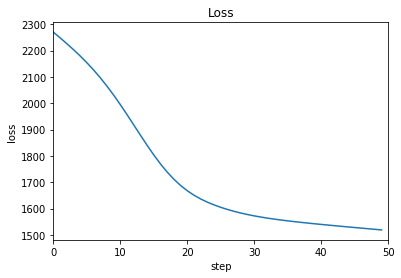

In [178]:
plt.plot(eps, epoch_loss)
plt.xlabel('step'), plt.ylabel('loss'), plt.title("Loss");
# plt.ylim((0, 50000))
plt.xlim((0, 50))

#### Test

In [179]:
test_error = list()
residuals = list()
y_true = list()
predictions = list()
_, batched_test_data = data_batcher(df, batch_size=batch_size)

for x, y in batched_test_data:
    y_true.append(y)
    prediction = predict(x, use_nonlinearity, hidden_weights, output_weights, hidden_bias, output_bias)
    predictions.append(prediction)
    test_error.append(loss_function(prediction, y))

print('Average sample error: {}'.format(np.mean(np.vstack(test_error))))

Average sample error: 1155.630528697192


#### Residuals

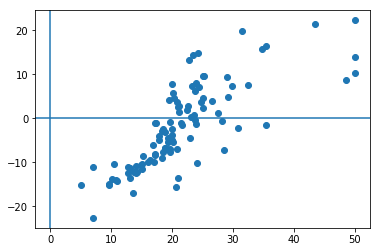

In [180]:
plt.scatter(np.vstack(y_true), np.vstack(y_true) - np.vstack(predictions))
plt.axhline(0);
plt.axvline(0);

#### $R^2$ result

In [160]:
r2_score(np.vstack(y_true), np.vstack(predictions))

-0.22983284666943016

## Visualizing the weights of the network

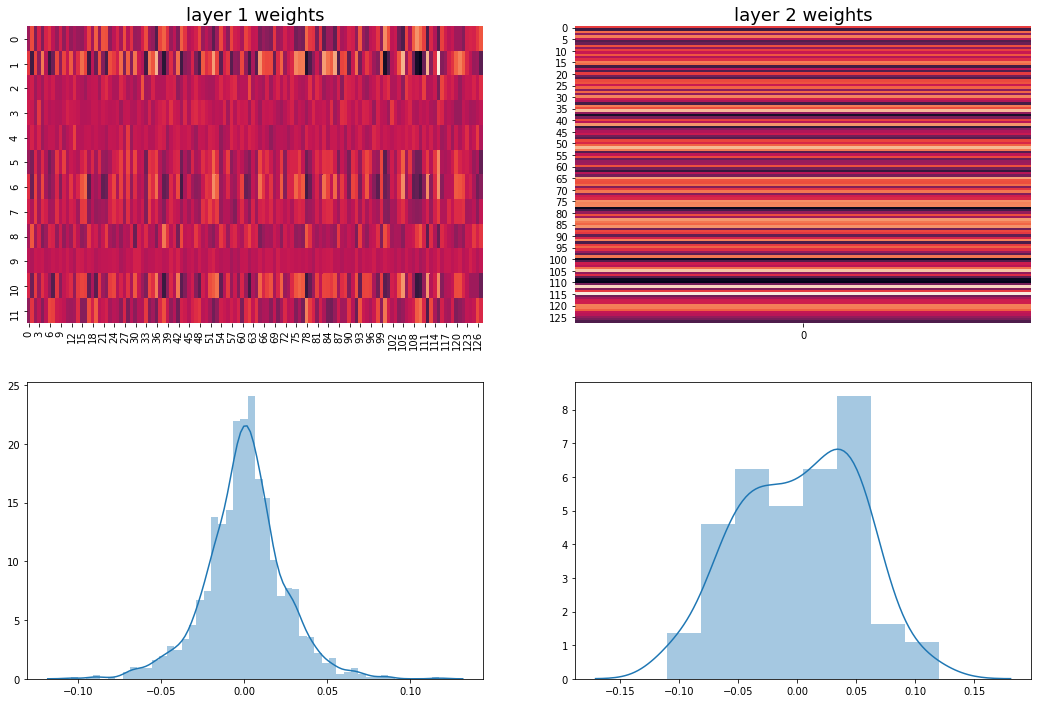

In [199]:
layers = [hidden_weights, output_weights,
          hidden_weights.flatten(), output_weights.flatten()]

fig, axs = plt.subplots(figsize=(18, 12), nrows=2, ncols=2)
bar = False
for ix, (layer, ax) in enumerate(zip(layers, axs.flatten())):
    if ix < 2:
        if ix == 2:
            bar = True
        sns.heatmap(layer, ax=ax, cbar=bar)
        ax.set_title('layer {} weights'.format(ix+1), fontdict={'fontsize': 18})
    else:
        sns.distplot(layer, ax=ax);

### Implement with Keras

In [218]:
from keras.models import Sequential
from keras.layers import Dense, Activation
import tensorflow as tf

In [239]:
tf.reset_default_graph()
model = Sequential()
model.add(Dense(32, input_dim=12, activation='relu', use_bias=True))
model.add(Dense(1))
model.compile(optimizer='rmsprop',
              loss='mean_squared_error',
              metrics=['acc'])

In [240]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                416       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 449
Trainable params: 449
Non-trainable params: 0
_________________________________________________________________


In [242]:
model.fit(df.drop('target', axis=1), df['target'], epochs=20);

Epoch 1/20
506/506 [==============================] - 0s 31us/step - loss: 47.0383 - acc: 0.0059
Epoch 2/20
506/506 [==============================] - 0s 27us/step - loss: 48.3396 - acc: 0.0079
Epoch 3/20
506/506 [==============================] - 0s 25us/step - loss: 47.6739 - acc: 0.0059
Epoch 4/20
506/506 [==============================] - 0s 26us/step - loss: 45.7154 - acc: 0.0138
Epoch 5/20
506/506 [==============================] - 0s 25us/step - loss: 48.9154 - acc: 0.0059
Epoch 6/20
506/506 [==============================] - 0s 24us/step - loss: 45.9988 - acc: 0.0099
Epoch 7/20
506/506 [==============================] - 0s 29us/step - loss: 47.2582 - acc: 0.0040
Epoch 8/20
506/506 [==============================] - 0s 24us/step - loss: 43.3609 - acc: 0.0119
Epoch 9/20
506/506 [==============================] - 0s 26us/step - loss: 46.3190 - acc: 0.0079
Epoch 10/20
506/506 [==============================] - 0s 24us/step - loss: 44.6985 - acc: 0.0119
Epoch 11/20
506/506 [========

# Summary

There is a quite a bit we can do to improve the results we obtained in this tutorial, and we've covered only some of most basic techniques involved with implementing a neural network from scratch.

Ideas to explore are:
 - normalizing the data during preprocessing
 - the consequence of using different types of activation functions
 - activation function saturation (see optimization notebook)
 - unwanted variable correlation (linear dependance across columns)